# Ratio-based crunchers

In this notebook we will go through two similar types of cruncher. This discussion may be easier to follow if you have read through the "Introduction to Crunchers" notebook, though the crunchers in it are independent. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    download_or_load_sr15,
)

<IPython.core.display.Javascript object>

## Download example data

We obtain example data by downloading a selection of the SR1.5 scenarios from the IIASA database. If the data has already been downloaded before, we will use that instead for brevity.

In [2]:
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file sr15_scenarios.csv


In [3]:
# We select only a subset of data for ease of plotting. We use one model for the infiller and a different one for the infillee.
filtered_sr15 = sr15_data.filter(model="MESSAGE*")
data_to_classify = sr15_data.filter(model="AIM/CGE 2.0", scenario="SSP2-34")

# Time-dependent ratio cruncher
This cruncher uses the 'time-dependent ratio' methodology. It is described by its docstring.

In [4]:
print(silicone.database_crunchers.TimeDepRatio.__doc__)


    Database cruncher which uses the 'time-dependent ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    time-dependent scaling factor. The scaling factor is the ratio of the
    follower variable to the lead variable. If the database contains many such pairs,
    the scaling factor is the ratio between the means of the values. By default, the
    calculation will include only values where the lead variable takes the same sign
    (+ or -) in the infilling database as in the case infilled. This prevents getting
    negative values of emissions that cannot be negative. To allow cases where we
    have no data of the correct sign, set `same_sign = False` in `derive_relationship`.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = R(t) * E_l(t)

    where :math:`E_f(t)` is emissions of the 

#### Infilling
This technique extracts only a single constant multiplier from all data fed in to the cruncher, so additional data does not radically change how it behaves. This cruncher works well for cases like splitting groups of gases into constituent parts (for which it is used in the multi-infiller decompose_collection_with_time_dep_ratio), but is less reliable for gases which may have negative emissions. 

In [5]:
# We need to only include scenarios with all data:
sr15_data_tdr = filtered_sr15.filter(
    scenario=filtered_sr15.filter(variable="Emissions|VOC").scenario
)

In [6]:
cruncher = silicone.database_crunchers.TimeDepRatio(sr15_data_tdr)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)


            Filler function derived from :obj:`TimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


In [7]:
filler_data = data_to_classify.filter(variable=["Emissions|CO2"])
filler_data = filler_data.filter(year=filtered_sr15["year"].unique())
filler_data.data

,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2005,34373.9345
1,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2010,38251.8756
2,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2020,43231.2477
3,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2030,38732.6422
4,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2040,31243.5853
5,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2050,23706.9432
6,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2060,17488.1653
7,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2070,12730.6701
8,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2080,9444.6482
9,AIM/CGE 2.0,SSP2-34,World,Emissions|CO2,Mt CO2/yr,2090,6695.9765


In [8]:
results = filler(filler_data)
results.head()

,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2005,180.267234
1,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2010,181.482855
2,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2020,187.808788
3,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2030,203.099076
4,AIM/CGE 2.0,SSP2-34,World,Emissions|VOC,Mt VOC/yr,2040,192.180315


pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


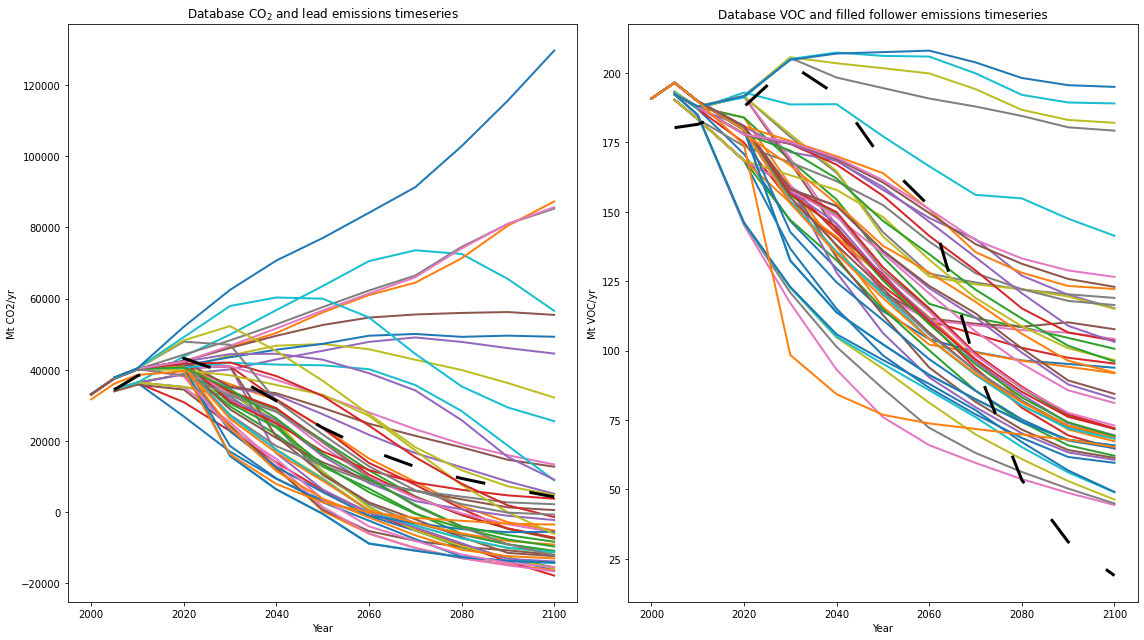

In [9]:
pkwargs = {"color": "scenario", "linewidth": 2}
infill_kwargs = {
    "color": "black",
    "linestyle": "--",
    "dashes": (10, 15),
    "linewidth": 3,
    "label": "To infill",
}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr.filter(variable="*CO2").plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").plot(ax=ax, **infill_kwargs)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_tdr.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

By default, the ratio is calculated using only the values where the lead variable takes the same sign in both infiller and infillee datasets. This guarantees that the output will always be positive if the input is always positive, but can distort results when the infillee lead approaches 0. It can be switched off if desired using `same_sign = False`: 

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


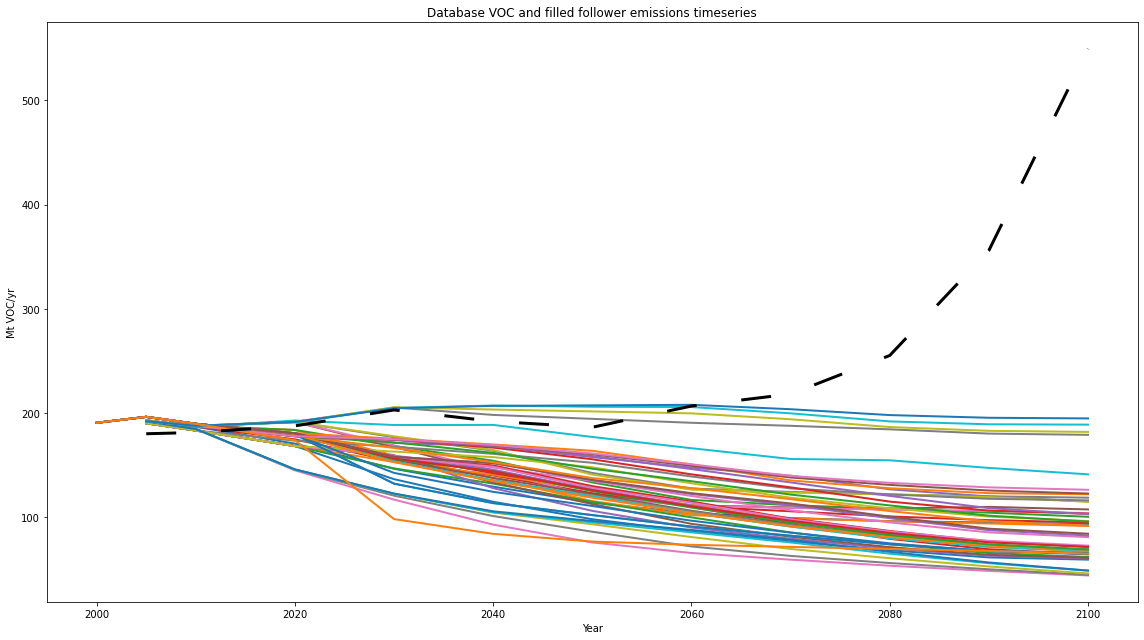

In [10]:
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results = filler(filler_data)
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sr15_data_tdr.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

Another factor about this infiller is that by default it will only use data with values at every point in time. In this case, we have very little data from 2000, meaning that the ratio is not representative of most data. This option can be switched off with `only_consistent_cases=False`. The problem could also be alieviated by filtering out the 2000 data, which in this case produces identical results and leaving `only_consistent_cases` as `True` (default). 

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


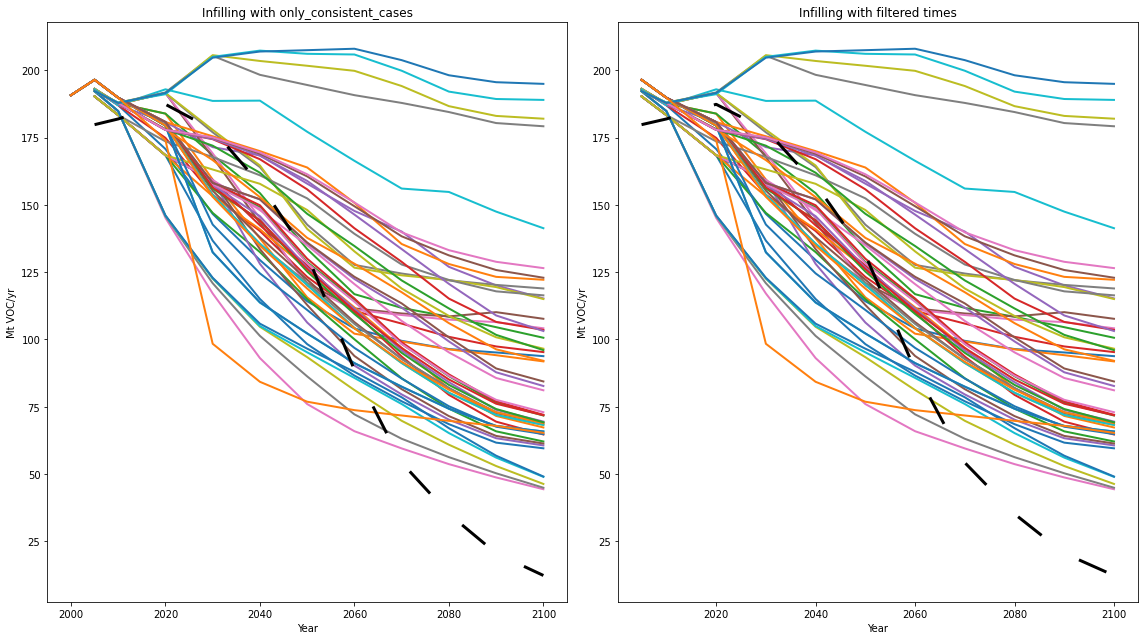

In [11]:
filler = cruncher.derive_relationship(
    "Emissions|VOC",
    ["Emissions|CO2"],
    same_sign=True,
    only_consistent_cases=False,
)
results = filler(filler_data)
time_rest_filler = silicone.database_crunchers.TimeDepRatio(
    sr15_data_tdr.filter(year=2000, keep=False)
).derive_relationship("Emissions|VOC", ["Emissions|CO2"], same_sign=True)
time_rest_results = time_rest_filler(filler_data)

pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Infilling with only_consistent_cases")
ax = fig.add_subplot(122)
sr15_data_tdr.filter(year=2000, keep=False).filter(variable="*VOC").plot(
    ax=ax, **pkwargs
)
time_rest_results.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Infilling with filtered times")
plt.tight_layout()

In [12]:
time_rest_results.filter(variable="*VOC").equals(
    results.filter(variable="*VOC")
)

True

In this case, this works well, because the mean CO2 value is always positive and moderately large. However when negatives predominate, allowing values of all signs may make results unstable, as shown below. 

In [13]:
sr15_data_tdr_red = sr15_data_tdr.filter(
    scenario=["*Baseline", "*-60"], keep=False
).filter(scenario="SSP*", keep=True)
cruncher = silicone.database_crunchers.TimeDepRatio(sr15_data_tdr_red)
filler_same_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=True
)
filler_dif_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results_same = filler_same_sign(filler_data)
results_dif = filler_dif_sign(filler_data)

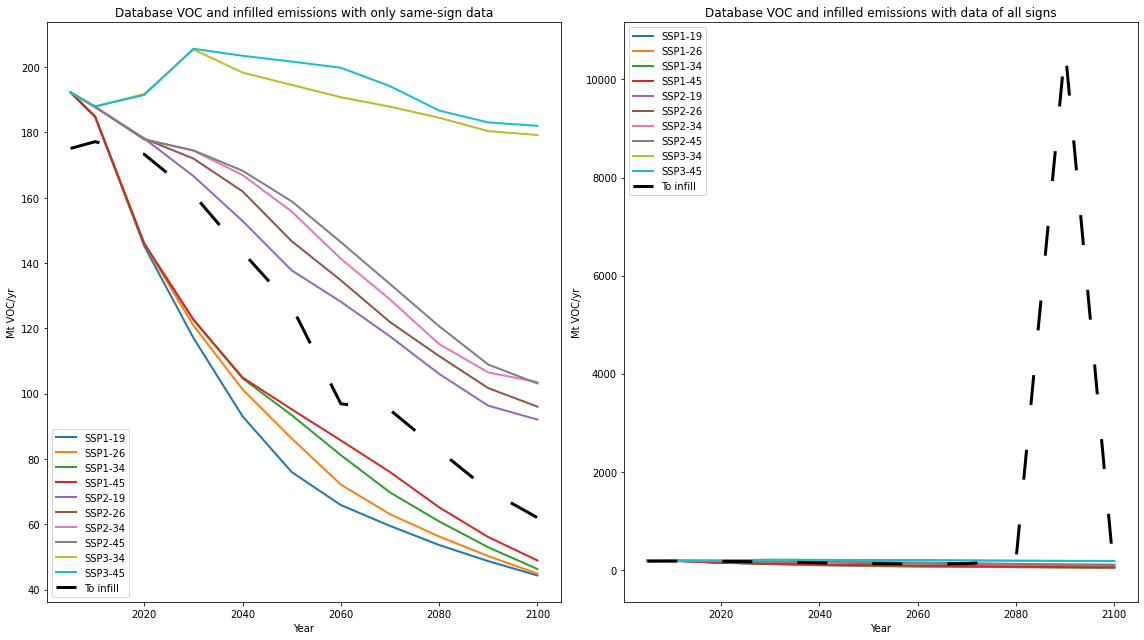

In [14]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr_red.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results_same.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Database VOC and infilled emissions with only same-sign data")
ax = fig.add_subplot(122)
sr15_data_tdr_red.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results_dif.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Database VOC and infilled emissions with data of all signs")

plt.tight_layout()

If all of the infiller database has a different sign to the infillee lead, same_sign cannot be used and will present an error:

In [15]:
sr15_data_tdr_red = sr15_data_tdr.filter(
    scenario=["SSP1-19", "SSP1-26"], keep=True
)
# These are cases where CO2 goes negative
cruncher = silicone.database_crunchers.TimeDepRatio(sr15_data_tdr_red)
filler_same_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=True
)
try:
    results_same = filler_same_sign(filler_data)
except ValueError as e:
    print(e)

Attempt to infill ['Emissions|CO2'] data using the time_dep_ratio cruncher where the infillee data has a sign not seen in the infiller database for year 2080.


With same_sign = False, no error will be reported but unrealistically high values and negative values will be returned:

In [16]:
filler_dif_sign = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], same_sign=False
)
results_dif = filler_dif_sign(filler_data)

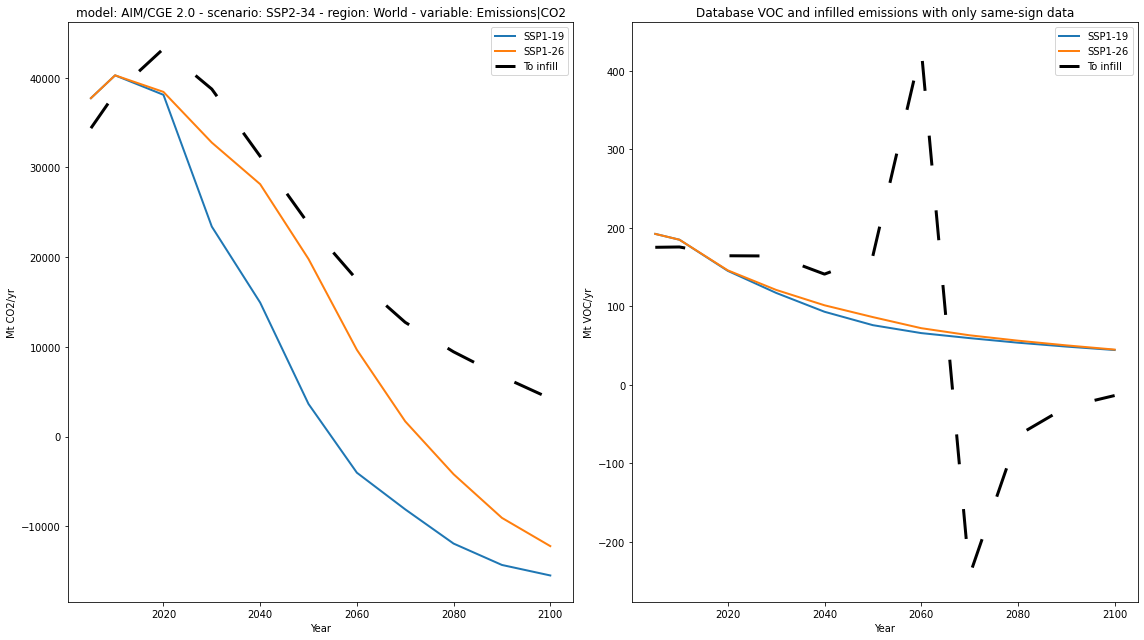

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr_red.filter(variable="*CO2").plot(ax=ax, **pkwargs)
filler_data.plot(ax=ax, **infill_kwargs)
ax = fig.add_subplot(122)
sr15_data_tdr_red.filter(variable="*VOC").plot(ax=ax, **pkwargs)
results_dif.filter(variable="*VOC").plot(ax=ax, **infill_kwargs)
ax.set_title("Database VOC and infilled emissions with only same-sign data")

plt.tight_layout()

### Latest time ratio
This infiller uses only a single timepoint to calculate the ratio between the lead data in the infillee database and the follower data in the infillee database. It is designed for the case where we have historic data up to a certain point. In the event that there is more than one data series at that time, the mean value is taken. All infilled timeseries will have the same follower value at that timepoint. 

In [18]:
print(silicone.database_crunchers.LatestTimeRatio.__doc__)


    Database cruncher which uses the 'latest time ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    scaling factor. The scaling factor is derived by calculating the ratio of the
    follower variable to the lead variable in the latest year in which the follower
    variable is available in the database. Additionally, since
    the derived relationship only depends on a single point in the database, no
    regressions or other calculations are performed.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = R * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable, both in the infillee database.

    :math:`R` is the scaling factor, calculated as

    .. math::
        R = \frac{ E_f(t_{\text{last}}) }{ e_l(t_{\text{

In [19]:
# To make sensible use of this, we will remove all data for one HFC except for in the chosen timeseries.
pretend_history = sr15_data.filter(model="MESSAGE-GLOBIOM*").filter(
    year=[2010, 2015]
)
follow = "Emissions|HFC|HFC125"
lead = ["Emissions|F-Gases"]
cruncher = silicone.database_crunchers.LatestTimeRatio(pretend_history)
filler = cruncher.derive_relationship(follow, lead)
print(filler.__doc__)


            Filler function derived from :obj:`LatestTimeRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            interpolate : bool
                If the key year for filling is not in ``in_iamdf``, should a value be
                interpolated?

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf`` and ``interpolate is
                False``.
            


In [20]:
# Create a database to infill
sr15_data_latest = sr15_data.filter(model="AIM*").filter(
    variable=follow, keep=False
)
result = filler(sr15_data_latest)
result.head()

,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|HFC|HFC125,kt HFC125/yr,2005,23.379685
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|HFC|HFC125,kt HFC125/yr,2010,31.104153
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|HFC|HFC125,kt HFC125/yr,2015,36.345708
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|HFC|HFC125,kt HFC125/yr,2020,41.583937
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|HFC|HFC125,kt HFC125/yr,2025,24.850936


In [21]:
sr15_data_latest.model

['AIM/CGE 2.0', 'AIM/CGE 2.1']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|HFC|HFC125'}, xlabel='Year', ylabel='kt HFC125/yr'>

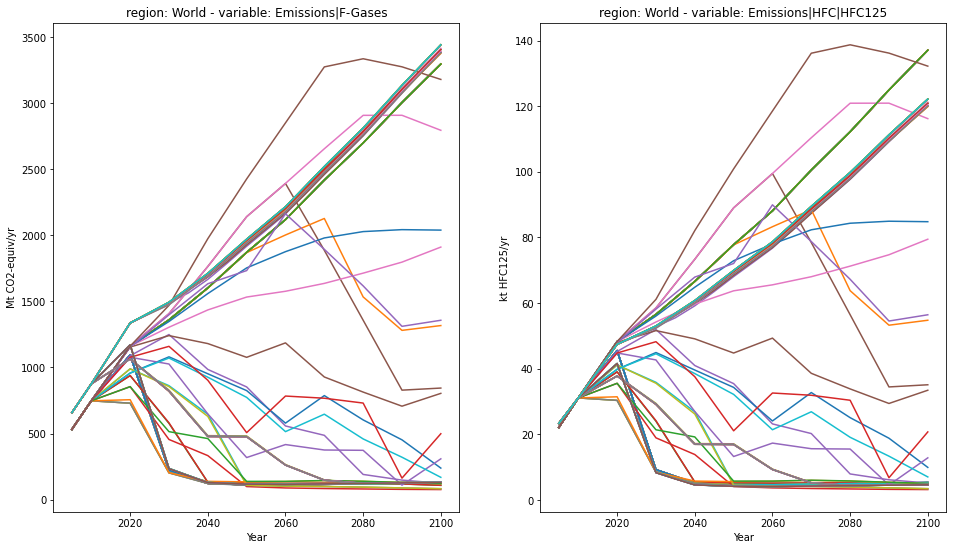

In [22]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_latest.filter(variable=lead).plot(ax=ax)
ax = fig.add_subplot(122)
result.plot(ax=ax)

Clearly the output values match the input values, rescaled to meet the input prediction at the latest time for which data is found in the database (2015). Note that data before this (2010) shows some spread - if we have historically accurate data for this time too, we will need to re-harmonise for it. 

### Constant ratio cruncher
This infiller simply multiples the lead emissions by a constant, which it must be told. It must also be told the units of the value it returns. It does not require an input infiller dataframe. This is mostly used in cases where we have very limited knowledge of a gas (perhaps it does not appear in the other databases) but project that it is proportional to another gas. It can also be used to infill 0s in the concentrations of gases with negligible concentrations. 

In [23]:
print(silicone.database_crunchers.ConstantRatio.__doc__)


    Database cruncher which uses the 'constant given ratio' technique.

    This cruncher does not require a database upon initialisation. Instead, it requires
    a constant and a unit to be input when deriving relations. This constant,
    :math:`s`, is the ratio of the follower variable to the lead variable i.e.:

    .. math::

        E_f(t) = s * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.
    


In [24]:
cruncher = silicone.database_crunchers.ConstantRatio()  # No input needed.
filler = cruncher.derive_relationship(
    "Emissions|VOC", ["Emissions|CO2"], 0.5, "kt VOC/yr"
)
print(filler.__doc__)


            Filler function derived from :obj:`TimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


In [25]:
sr15_data_cr = sr15_data.filter(
    model="MESSAGE-GLOBIOM*", scenario="SSP2*", variable="Emissions|CO2"
)
infilled = filler(sr15_data_cr)
infilled.head()

silicone.database_crunchers.constant_ratio - WARNING: Note that the lead variable ['Emissions|CO2'] goes negative.


Note that the lead variable ['Emissions|CO2'] goes negative.


,model,scenario,region,variable,unit,year,value
0,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2005,18883.620915
1,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2010,20156.751015
2,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2020,20465.660870
3,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2030,11816.564265
4,MESSAGE-GLOBIOM 1.0,SSP2-19,World,Emissions|VOC,kt VOC/yr,2040,5762.064700


In [26]:
infilled = filler(sr15_data_cr)

silicone.database_crunchers.constant_ratio - WARNING: Note that the lead variable ['Emissions|CO2'] goes negative.


Note that the lead variable ['Emissions|CO2'] goes negative.


Text(0.5, 1.0, 'Database CO2 and lead emissions timeseries')

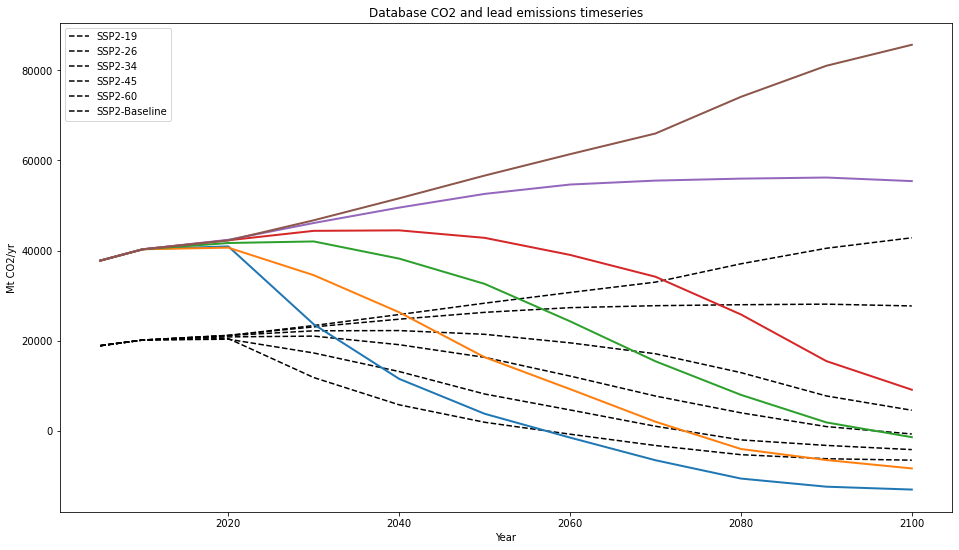

In [27]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
infilled.plot(ax=ax, color="black", linestyle="--")
sr15_data_cr.filter(variable="*CO2").plot(ax=ax, **pkwargs)
ax.set_title("Database CO2 and lead emissions timeseries")

This straightforwardly adds another series in fixed ratio and different units, as expected. 